In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

##事前準備

In [3]:
# work spaceにコピー
%%bash

mkdir /content/data
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/add_resize_512.zip /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/add_trim_resize_512.zip /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/df_add.csv /content/data/

unzip /content/data/add_resize_512.zip -d "/content/data/"
unzip /content/data/add_trim_resize_512.zip -d "/content/data/"

Archive:  /content/data/add_resize_512.zip
   creating: /content/data/add_resize_512/
  inflating: /content/data/add_resize_512/b24dd49a.jpg  
  inflating: /content/data/add_resize_512/956b1301.jpg  
  inflating: /content/data/add_resize_512/0b35b06a.jpg  
  inflating: /content/data/add_resize_512/4432cb27.jpg  
  inflating: /content/data/add_resize_512/3f9eb849.jpg  
  inflating: /content/data/add_resize_512/00e2c609.jpg  
  inflating: /content/data/add_resize_512/6fa0b901.jpg  
  inflating: /content/data/add_resize_512/457f8d7f.jpg  
  inflating: /content/data/add_resize_512/b1d7183e.jpg  
  inflating: /content/data/add_resize_512/b458944d.jpg  
  inflating: /content/data/add_resize_512/27cf14df.jpg  
  inflating: /content/data/add_resize_512/0791963c.jpg  
  inflating: /content/data/add_resize_512/e5e53c78.jpg  
  inflating: /content/data/add_resize_512/f525eef4.jpg  
  inflating: /content/data/add_resize_512/2f1d593c.jpg  
  inflating: /content/data/add_resize_512/a0bd5008.jpg  
  

In [4]:
# path
DATA_ROOT = "/content/data/"

NON_TRIM_PATH = "/content/data/add_resize_512/"
TRIM_PATH = "/content/data/add_trim_resize_512/"

In [5]:
# データフレーム
## path列は画像リサイズ時に使用したものであり更新が必要
df = pd.read_csv(DATA_ROOT + "df_add.csv")

## non_trimのpath更新
df = df.drop('path', axis=1)
paths = glob(NON_TRIM_PATH + '*.jpg')
df_path = pd.DataFrame({'path': paths})
df_path["filename"] = df_path["path"].apply(lambda x: x.split("/")[-1])
df = pd.merge(df, df_path, on='filename')

## trimのpath更新
df = df.drop('path_trim', axis=1)
paths = glob(TRIM_PATH + '*_trim.jpg')
df_path = pd.DataFrame({'path_trim': paths})
df_path["filename_trim"] = df_path["path_trim"].apply(lambda x: x.split("/")[-1])
df = pd.merge(df, df_path, on='filename_trim')

df.head(3)

,filename,filename_trim,class,path,path_trim
0,172e1676.jpg,172e1676_trim.jpg,USB_Micro_B_W,/content/data/add_resize_512/172e1676.jpg,/content/data/add_trim_resize_512/172e1676_tri...
1,2ed927e9.jpg,2ed927e9_trim.jpg,USB_Mini,/content/data/add_resize_512/2ed927e9.jpg,/content/data/add_trim_resize_512/2ed927e9_tri...
2,d62e1c29.jpg,d62e1c29_trim.jpg,HDMI,/content/data/add_resize_512/d62e1c29.jpg,/content/data/add_trim_resize_512/d62e1c29_tri...


##matching





https://code-graffiti.com/opencv-template-matching-in-python/

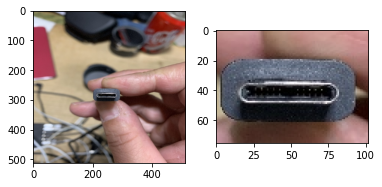

In [6]:
# chack image
i = np.random.randint(len(df))

path = df["path"][i]
full_img = cv2.imread(path)
full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

path = df['path_trim'][i]
trim_img = cv2.imread(path)
trim_img = cv2.cvtColor(trim_img, cv2.COLOR_BGR2RGB)

fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
#plt.axis('off')
plt.imshow(full_img)

ax2 = fig.add_subplot(1, 2, 2)
#plt.axis('off')
plt.imshow(trim_img)

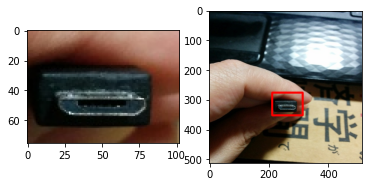

(313, 352)


In [7]:
# templete_matching関数定義
def templete_matching(full, trim):

    h, w, _ = trim.shape
    #methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR','cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
    methods = ['cv2.TM_CCOEFF_NORMED']

    for m in methods:
        full_copy = full

        method = eval(m)
        res = cv2.matchTemplate(full_copy, trim, method)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc    
        else:
            top_left = max_loc
        

        bottom_right = (top_left[0] + w, top_left[1] + h)


        return top_left, bottom_right


# test
i = np.random.randint(len(df))

path = df["path"][i]
full_img = cv2.imread(path)
full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

path = df['path_trim'][i]
trim_img = cv2.imread(path)
trim_img = cv2.cvtColor(trim_img, cv2.COLOR_BGR2RGB)

top_left, bottom_right = templete_matching(full_img, trim_img)


cv2.rectangle(full_img, top_left, bottom_right, 255, 5)
        
        
plt.subplot(121)
plt.imshow(trim_img)
    
plt.subplot(122)
plt.imshow(full_img)

plt.show()

print(bottom_right)

In [9]:
# df更新
box = []

for i in tqdm(range(len(df))):
    path = df["path"][i]
    full_img = cv2.imread(path)
    full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

    path = df['path_trim'][i]
    trim_img = cv2.imread(path)
    trim_img = cv2.cvtColor(trim_img, cv2.COLOR_BGR2RGB)

    top_left, bottom_right = templete_matching(full_img, trim_img)

    Xmin = top_left[0]
    Ymin = top_left[1]
    Xmax = bottom_right[0]
    Ymax = bottom_right[1]

    box.append([Xmin, Ymin, Xmax, Ymax])

df["resized_box"] = box

100%|██████████| 1648/1648 [01:30<00:00, 18.14it/s]


In [10]:
df["resized_box"].isnull().sum()

0

In [11]:
resize_size = 512
MYDRIVE = f"/content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_{resize_size}_datasets/"
df.to_csv(MYDRIVE + "df_add.csv", index=False)